In [1]:
import numpy as np
import pandas as pd
import pickle
import cv2
import matplotlib.pyplot as plt

import time
from sys import getsizeof

# preprocessing
from config import DATA_CSV, PIXEL_ARRAY, DTYPE, Y_LABEL
from config import FEATURES, OUTPUT_FOLDER, FORMAT
from preprocessing import to_arr
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

# image processing
# from model import run_model, run_desc_model
from image_processing import sift_ext, surf_ext, orb_ext
from image_processing import sift_des, surf_des, orb_des
from image_processing import generate_bag
# from image_processing import generate_histo

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from config import TRANSFORMATION_LIST, EXTRACTION_LIST
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import accuracy_score, log_loss

# model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

RANDOM_STATE = 0
# import warnings
# warnings.filterwarnings("ignore")

In [ ]:
data = np.load(PIXEL_ARRAY, allow_pickle=True)
data = pd.DataFrame({'Pixel': data})
data.head()

In [10]:
y = np.load(Y_LABEL)
np.unique(y, return_counts=True)

(array([0, 1]), array([1506,  625]))

### X

In [4]:
X = np.load(OUTPUT_FOLDER + 'll.npy', allow_pickle=True)
X_arr = to_arr(X)

/home/xunwei/anaconda3/envs/fyp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3319: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
print(X[0].shape) #wavelet
print(X_arr[0].shape) #must

(258, 258)
(66564,)


In [6]:
print(X[0].shape) #sift
print(X_arr[0].shape) #cannot

(1999, 128)
(262144,)


In [4]:
print(X[0].shape) #fft
print(X_arr[0].shape) #must

(512, 512)
(262144,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## Resample

### Random over sampling

In [14]:
ros = RandomOverSampler(random_state=0)
ros.fit(X_arr, y)
X_res, y_res = ros.fit_resample(X_arr, y)

In [29]:
np.unique(y_res, return_counts=True)

(array([0, 1]), array([1506, 1506]))

### ADASYN

In [ ]:
smote = ADASYN(random_state=0)
smote.fit(X_arr, y)
X_res, y_res = smote.fit_resample(X_arr, y)

In [11]:
transformation_transformer = Pipeline(steps = [
    ('to_arr', FunctionTransformer(to_arr))
])

In [19]:
X_trans = transformation_transformer.transform(X)
# X = transformation_transformer.fit(y)

In [22]:
np.array_equal(X_arr, X_trans)

True

### SMOTE

In [21]:
smote = SMOTE(random_state=RANDOM_STATE)
smote.fit(X_trans, y)
X_res, y_res = smote.fit_resample(X_trans, y)

In [32]:
smote = SMOTE(random_state=RANDOM_STATE)
smote.fit(X_arr, y)
X_res, y_res = smote.fit_resample(X_arr, y)

ValueError: setting an array element with a sequence.

## Clustering

In [9]:
img_col = np.load(OUTPUT_FOLDER + 'sift.npy', allow_pickle=True)

# col = np.vstack(np.uint32(i) for i in img_col)
# print(np.array_equal(bag, col))
bag = generate_bag(img_col)

print(getsizeof(bag))
print(col.nbytes)

print(len(img_col))
print(np.shape(bag))
print(col.shape)

In [6]:
k = 2 * 10
batch_size = 45

In [7]:
mbk = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(bag)
t_mini_batch = time.time() - t0

In [8]:
t_mini_batch

111.65457677841187

In [12]:
t_mini_batch

238.77364921569824

In [24]:
histo_list = []
for descriptors in img_col:
#     print(descriptors)
#     print("+++++++++")
    histo = np.zeros(k)
    nkp = np.size(descriptors)

    for d in descriptors:
        idx = mbk.predict([d])
        histo[idx] += 1 / nkp  # Because we need normalized histograms, I prefere to add 1/nkp directly

    histo_list.append(histo)

In [26]:
histo_list

[array([0.0003791 , 0.00035174, 0.00089498, 0.00044163, 0.00029702,
        0.00033611, 0.00038691, 0.00028921, 0.00023058, 0.00026185,
        0.00019541, 0.00021495, 0.0009028 , 0.00020713, 0.00049243,
        0.00055887, 0.00025403, 0.00065658, 0.00024231, 0.00021886]),
 array([0.00048114, 0.00031499, 0.0005296 , 0.0004396 , 0.00037038,
        0.00031845, 0.00049499, 0.00034961, 0.00029768, 0.00034268,
        0.00030115, 0.00036691, 0.00054691, 0.00025269, 0.00053306,
        0.0006196 , 0.00027345, 0.00041884, 0.00024922, 0.00031153]),
 array([0.00046754, 0.00031295, 0.00031672, 0.00050525, 0.00046754,
        0.00040722, 0.00050902, 0.00032049, 0.00020738, 0.00042984,
        0.00035066, 0.00037328, 0.00038082, 0.00024885, 0.00047885,
        0.00066361, 0.00028279, 0.00040344, 0.00025639, 0.00042984]),
 array([0.0003249 , 0.00033237, 0.00041826, 0.00037718, 0.0004556 ,
        0.00029129, 0.00051909, 0.00048921, 0.00027635, 0.00038838,
        0.00030623, 0.00035477, 0.00042573

## Batch training

In [2]:
from sklearn.linear_model import SGDClassifier

## Pipeline

### Transformation

to_arr(X)
- PCA
- MinMax
- Model

In [5]:
transformation_transformer = Pipeline(steps = [
    ('to_arr', FunctionTransformer(to_arr)),
    ('minmax', MinMaxScaler()),
    ('pca', PCA())
])

### Extraction

np.array(histo_list)
    
- K-means
- histo
- models

In [8]:
extraction_transformer = Pipeline(steps = [
#     ('cluster', KMeans()),
    
])

### ColumnTransformer 

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('trans', transformation_transformer, TRANSFORMATION_LIST),
#         ('ext', extraction_transformer, EXTRACTION_LIST)
    ])

## Model Selection

In [44]:
classifier = DecisionTreeClassifier(random_state=9)
classifiers = [
    ('NB', GaussianNB()),
    ('LSVC', LinearSVC()),
    ('SVC', SVC(random_state=9, gamma='scale')),
    ('LOGR', LogisticRegression(random_state=9, solver='lbfgs')),
    ('SGD', SGDClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier(random_state=9)),
    ('RF', RandomForestClassifier(n_estimators=100, random_state=9)),
    ('ABC', AdaBoostClassifier()),
    ('GBC', GradientBoostingClassifier()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('MLP', MLPClassifier())
]

# classifiers = [
#     GaussianNB(),
#     LinearSVC(),
#     SVC(random_state=9, gamma='scale'),
#     LogisticRegression(random_state=9, solver='lbfgs'),
#     SGDClassifier(),
#     KNeighborsClassifier(),
#     DecisionTreeClassifier(random_state=9),
#     RandomForestClassifier(n_estimators=100, random_state=9),
#     AdaBoostClassifier(),
#     GradientBoostingClassifier(),
#     LinearDiscriminantAnalysis(),
#     MLPClassifier()
# ]

In [29]:
result_feature = []

for name, classifier in classifiers:
    pipe = Pipeline(steps=[
#         ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)

    result = {}
    result[name] = score
    print(result)
#     print(classifier)
#     print("model score: %.3f" % score)

{'NB': 0.7058823529411765}
{'LSVC': 0.7647058823529411}
{'SVC': 0.7647058823529411}
{'LOGR': 0.7647058823529411}
{'SGD': 0.5882352941176471}
{'KNN': 0.47058823529411764}
{'CART': 0.6470588235294118}
{'RF': 0.5882352941176471}
{'ABC': 0.29411764705882354}
{'GBC': 0.7647058823529411}


/home/xunwei/anaconda3/envs/fyp/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


{'LDA': 0.4117647058823529}
{'MLP': 0.7058823529411765}


### Pipeline with Cross-Validation (cross_val_score)

In [16]:
%%time
pipeline = Pipeline(steps=[
    ('transform', transformation_transformer),
    ('classifier', DecisionTreeClassifier(random_state=9))
])

scores = cross_val_score(pipeline,X_train,y_train,cv=10,scoring='accuracy')
print(scores)

/home/xunwei/anaconda3/envs/fyp/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:141: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return self._transform(X, func=self.func, kw_args=self.kw_args)
/home/xunwei/anaconda3/envs/fyp/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:141: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return self._transform(X, func=self.func, kw_args=self.kw_args)
/home/xunwei/anaconda3/envs/fyp/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:141: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for no

[0.59064327 0.64327485 0.59649123 0.58479532 0.63529412 0.65882353
 0.55294118 0.58823529 0.62941176 0.64117647]
CPU times: user 36min 43s, sys: 5min 25s, total: 42min 8s
Wall time: 12min 46s


## Random search

https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html

In [40]:
# # specify parameters and distributions to sample from
# param_dist = {"max_depth": [3, None],
#               "max_features": sp_randint(1, 11),
#               "min_samples_split": sp_randint(2, 11),
#               "criterion": ["gini", "entropy"]}

# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": [1, None],
              "min_samples_split": sp_randint(2, 11),
              "criterion": ["gini", "entropy"]}

In [ ]:
# run randomized search
n_iter_search = 5
random_search = RandomizedSearchCV(classifier, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=10, iid=False)

In [101]:
X = data['LL']
X = to_arr(X) #ll must to arr
#sift must use after histo generated

y = data['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

/home/xunwei/anaconda3/envs/fyp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3319: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [102]:
random_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [46]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
report(random_search.cv_results_)

In [47]:
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.673 (std: 0.136)
Parameters: {'max_features': None, 'max_depth': 3, 'criterion': 'gini'}

Model with rank: 1
Mean validation score: 0.673 (std: 0.136)
Parameters: {'max_features': None, 'max_depth': None, 'criterion': 'gini'}

Model with rank: 3
Mean validation score: 0.616 (std: 0.160)
Parameters: {'max_features': None, 'max_depth': 3, 'criterion': 'entropy'}



## GridSearch

In [40]:
param_grid = { 
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth' : np.linspace(1, 32, 32, endpoint=True, dtype='int'),
    'classifier__min_samples_split' : np.linspace(2, 50, 49, endpoint=True, dtype='int')
}

classifier = DecisionTreeClassifier(min_samples_split=4, random_state=0)

pipe = Pipeline(steps=[
    ('classifier', classifier)
])

In [21]:
%%time
# instantiate the grid
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='accuracy')

# fit the grid with data
grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [26]:
# examine the best model

# Single best score achieved across all params (min_samples_split)
print(grid.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid.best_estimator_)

0.6060606060606061
{'classifier__min_samples_split': 29}
Pipeline(memory=None,
         steps=[('classifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=None, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1,
                                        min_samples_split=29,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=0,
                                        splitter='best'))],
         verbose=False)


In [48]:
report(grid)

NameError: name 'grid' is not defined

In [4]:
def generate_histo(img_col, ext):
    # initialize feature extraction method
    if ext == 'sift':
        ext = sift_ext
        desc = sift_des
    elif ext == 'surf':
        ext = surf_ext
        desc = surf_des
    elif ext == 'orb':
        ext = orb_ext
        desc = orb_des
    else:
        return

    # if ext == 'sift':
    #     ext = cv2.xfeatures2d.SIFT_create()
    # elif ext == 'surf':
    #     ext = cv2.xfeatures2d.SURF_create()
    # elif ext == 'orb':
    #     ext = cv2.ORB_create(nfeatures=1500)
    # else:
    #     return

    # convert to descriptors
    img_col = img_col.apply(desc)

    # generate bag of words
    bag = generate_bag(img_col)


    # clustering
    k = 2 * 10
    kmeans = KMeans(n_clusters=k).fit(bag)
    kmeans.verbose = False

    # generate histogram/feature vector
    histo_list = []
    for img in img_col:
        img = np.uint8(img)
        kp, des = ext(img)

        histo = np.zeros(k)
        nkp = np.size(kp)

        for d in des:
            idx = kmeans.predict([d])
            histo[idx] += 1 / nkp  # Because we need normalized histograms, I prefere to add 1/nkp directly

        histo_list.append(histo)
    return histo_list

In [26]:
sift_histo = generate_histo(data['pixel'], "sift")

In [ ]:
surf_histo = generate_histo(data['pixel'], "surf")

In [ ]:
orb_histo = generate_histo(data['pixel'], "orb")

### Find opt k

In [3]:
def get_optk(desc):
    if desc == 'surf':
        name = '(SURF)'
        method = surf_des
    elif desc == 'sift':
        name = '(SIFT)'
        method = sift_des
    else:
        name = '(ORB)'
        method = orb_des
        
    img_col = data['pixel']
    img_col = img_col.apply(method)
    bag = generate_bag(img_col)
    
    Sum_of_squared_distances = []
    Silhouette_scores = []

    K = range(2,25)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(bag)
        Sum_of_squared_distances.append(km.inertia_)

        labels = km.labels_
        Silhouette_scores.append(silhouette_score(bag, labels, metric = 'euclidean'))
        
    with open(desc + 'sum.pkl', 'rb') as f:
        pickle.dump(Sum_of_squared_distances, f)

    with open(desc + 'sil.pkl', 'rb') as f:
        pickle.dump(Silhouette_scores, f)
        
    fig, (ax1, ax2) = plt.subplots(2)
    # fig.suptitle('Axes values are scaled individually by default')
    ax1.plot(K, Sum_of_squared_distances, 'bx-')
    ax1.set_title('Elbow Method For Optimal k ' + name)

    ax2.plot(K, Silhouette_scores, 'bx-')
    ax2.set_title('Silhouette Method For Optimal k ' + name)

    plt.tight_layout()
    plt.savefig(desc + '.svg', dpi=300, format='svg')

In [ ]:
%%time
desc = 'sift'

if desc == 'surf':
    name = '(SURF)'
    method = surf_des
elif desc == 'sift':
    name = '(SIFT)'
    method = sift_des
else:
    name = '(ORB)'
    method = orb_des

img_col = data['pixel']
img_col = img_col.apply(method)
bag = generate_bag(img_col)

Sum_of_squared_distances = []
Silhouette_scores = []

K = range(2,25)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(bag)
    Sum_of_squared_distances.append(km.inertia_)

    labels = km.labels_
    Silhouette_scores.append(silhouette_score(bag, labels, metric = 'euclidean'))

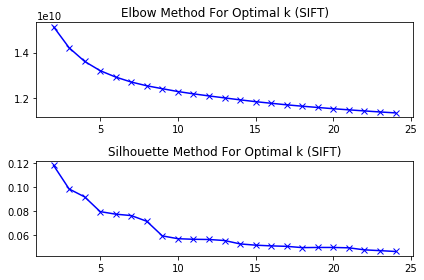

In [14]:
fig, (ax1, ax2) = plt.subplots(2)
# fig.suptitle('Axes values are scaled individually by default')
ax1.plot(K, Sum_of_squared_distances, 'bx-')
ax1.set_title('Elbow Method For Optimal k ' + name)

ax2.plot(K, Silhouette_scores, 'bx-')
ax2.set_title('Silhouette Method For Optimal k ' + name)

plt.tight_layout()
plt.savefig(desc + '.svg', dpi=300, format='svg')


In [3]:
with open('sum.pkl', 'rb') as f:
    Sum_of_squared_distances = pickle.load(f)
    
with open('sil.pkl', 'rb') as f:
    Silhouette_scores = pickle.load(f)

In [ ]:
get_optk('sift')

In [ ]:
get_optk('surf')

In [ ]:
get_optk('orb')